# Data
## 数据来源
![](../images/play_the_game_by_betteo.jpg)


详见：
* [Network of Thrones](https://www.macalester.edu/~abeverid/thrones.html)
* [NETWORK OF THRONES | A Song of Math and Westeros](https://networkofthrones.wordpress.com/)

## 数据描述
![](../images/dd1.png)

* 以同时登场的次数作为边的权重(**Weight**)
* 无向图，**Source**和**Target**仅为方便存储

# Dependency
* networks
* numpy
* pandas
* matplotlib

# Code and Data Analysis

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 读入数据

In [2]:
data = pd.read_csv("../data/stormofswords.csv")

In [3]:
data.head()

Source   Target  Weight
0  Aemon    Grenn       5
1  Aemon  Samwell      31
2  Aerys    Jaime      18
3  Aerys   Robert       6
4  Aerys   Tyrion       5

In [4]:
data.tail()

Source       Target  Weight
347   Walder        Petyr       6
348   Walder       Roslin       6
349   Walton        Jaime      10
350  Ygritte       Qhorin       7
351  Ygritte  Rattleshirt       9

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  352 non-null    object
 1   Target  352 non-null    object
 2   Weight  352 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.4+ KB


In [6]:
number_characters = len(set(data["Source"].unique()) | set(data["Target"].unique()))
number_characters

107

In [7]:
len(set(data["Source"].unique()) & set(data["Target"].unique()))

64

* 352行，即352条边
* 107个不同人物，即107个节点（两个人物列表有重合）

## 建立图

In [8]:
characters = list(set(data["Source"].unique()) | set(data["Target"].unique()))

In [9]:
G = nx.Graph()

In [10]:
G.add_nodes_from(characters)

In [11]:
for i in range(len(data)):
    G.add_edge(data.loc[i, "Source"], data.loc[i, "Target"], weight=data.loc[i, "Weight"])

## 分析

### 节点度的分析

节点的度反映了某个角色认识其他角色的数量（这里把同时出场当作认识）

In [12]:
degree = [G.degree(c) for c in characters]
degree = pd.DataFrame({"character": characters, "degree_value": degree})
degree

character  degree_value
0        Karl             1
1    Margaery             7
2        Arya            19
3      Qhorin             5
4       Jeyne             2
..        ...           ...
102   Podrick             5
103   Samwell            15
104   Illyrio             1
105      Mace             3
106   Shireen             1

[107 rows x 2 columns]

In [13]:
plt.style.use("seaborn")

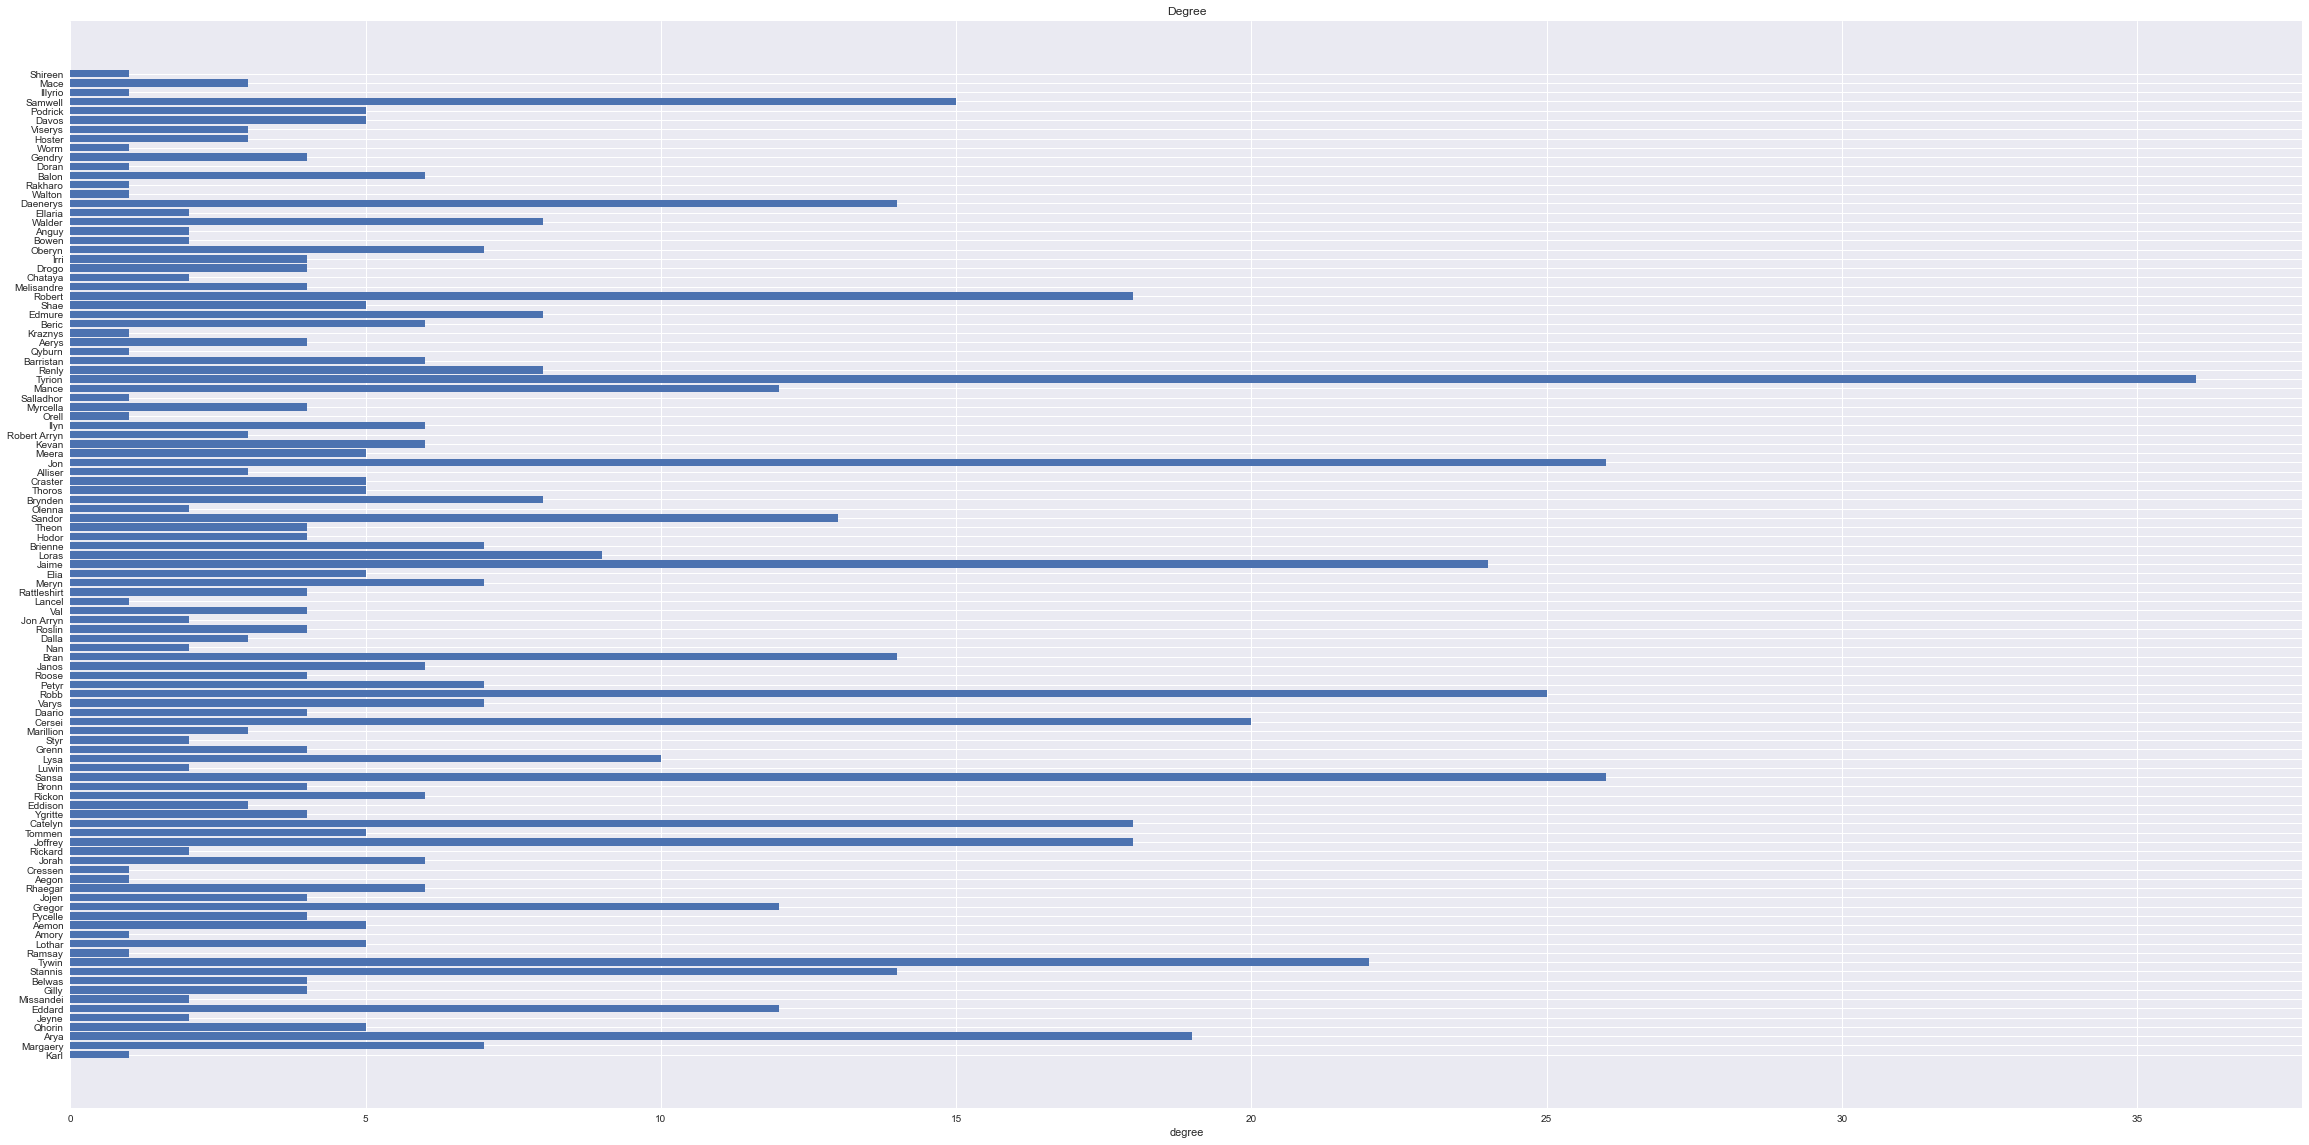

In [14]:
plt.figure(figsize=(40, 20))
plt.barh(degree["character"], degree["degree_value"]);
plt.title("Degree")
plt.xlabel("degree");

下面进行排序并分析：

In [15]:
degree_sorted = degree.sort_values(by=["degree_value"], ascending=False)

In [16]:
degree_sorted.head(5)

character  degree_value
73    Tyrion            36
64       Jon            26
30     Sansa            26
39      Robb            25
53     Jaime            24

|  角色   | 度  |
|  ----  | ----  |
|  <img src="../images/tyrion.png" width = "300" height = "200" /> | 36 |
| <img src="../images/sansa.png" width = "300" height = "200" />  | 26 |
| <img src="../images/jon.png" width = "300" height = "200" /> | 26 |

In [17]:
degree["degree_value"].mean()

6.579439252336448

**平均度为6.57**

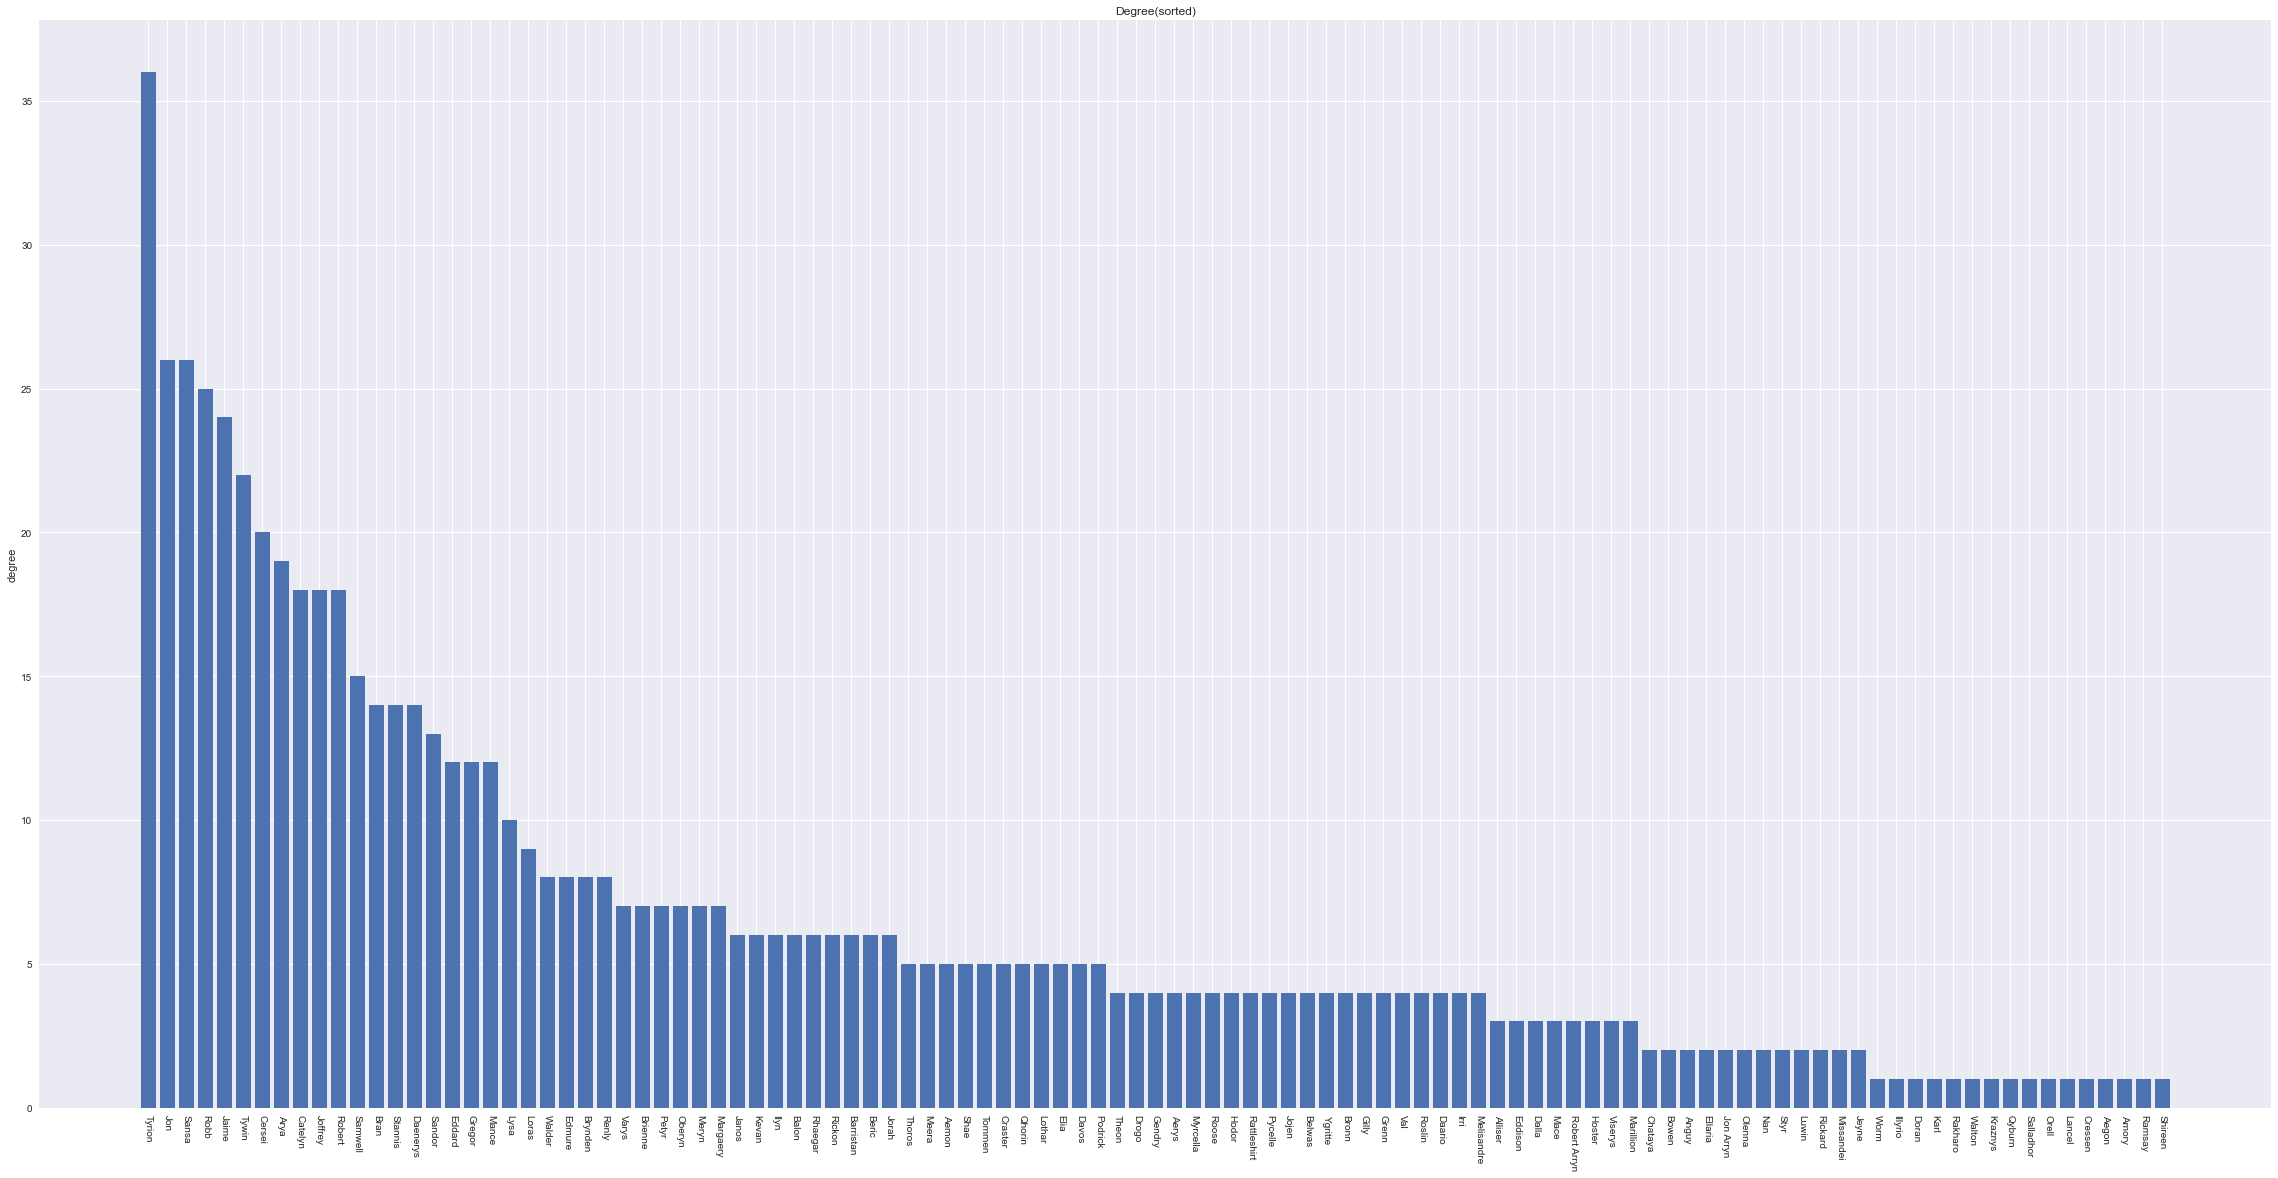

In [18]:
plt.figure(figsize=(40, 20))
plt.bar(degree_sorted["character"], degree_sorted["degree_value"]);
plt.title("Degree(sorted)")
plt.ylabel("degree");
plt.xticks(rotation=-90);

* 平均每个角色认识7个左右的其他角色
* Tyrion Lannister的节点的度尤其高，一定程度上说明了该角色最为重要（当然不仅这一个指标说明，见下文）

### 登场次数分析

#### 同时登场的次数的分析

In [19]:
data_sorted = data.sort_values(by=["Weight"], ascending=False)

In [20]:
data_sorted

Source   Target  Weight
30      Bran    Hodor      96
124    Jaime  Brienne      88
288    Sansa   Tyrion      77
162      Jon    Mance      69
151  Joffrey   Tyrion      54
..       ...      ...     ...
63    Cersei     Elia       4
62    Cersei    Bronn       4
185   Lothar   Roslin       4
58   Catelyn  Stannis       4
220  Rickard  Brynden       4

[352 rows x 3 columns]

毫无疑问，关系最密切的是这二位：

<img src="../images/hodor.png" width = "300" height = "200" />

#### 登场次数的分析（加权中心度）

In [21]:
character_n = [sum([G[c][x]["weight"] for x in list(G[c])]) for c in characters]

In [22]:
appear_n = pd.DataFrame({"character": characters, "n": character_n})
appear_n = appear_n.sort_values(by=["n"], ascending=False)
appear_n

character    n
73     Tyrion  551
64        Jon  442
30      Sansa  383
53      Jaime  372
43       Bran  344
..        ...  ...
96      Doran    5
13      Amory    5
106   Shireen    5
20    Cressen    4
11     Ramsay    4

[107 rows x 2 columns]

In [23]:
appear_n["n"].mean()

80.82242990654206

In [24]:
len(appear_n[appear_n["n"] > appear_n["n"].mean()])

33

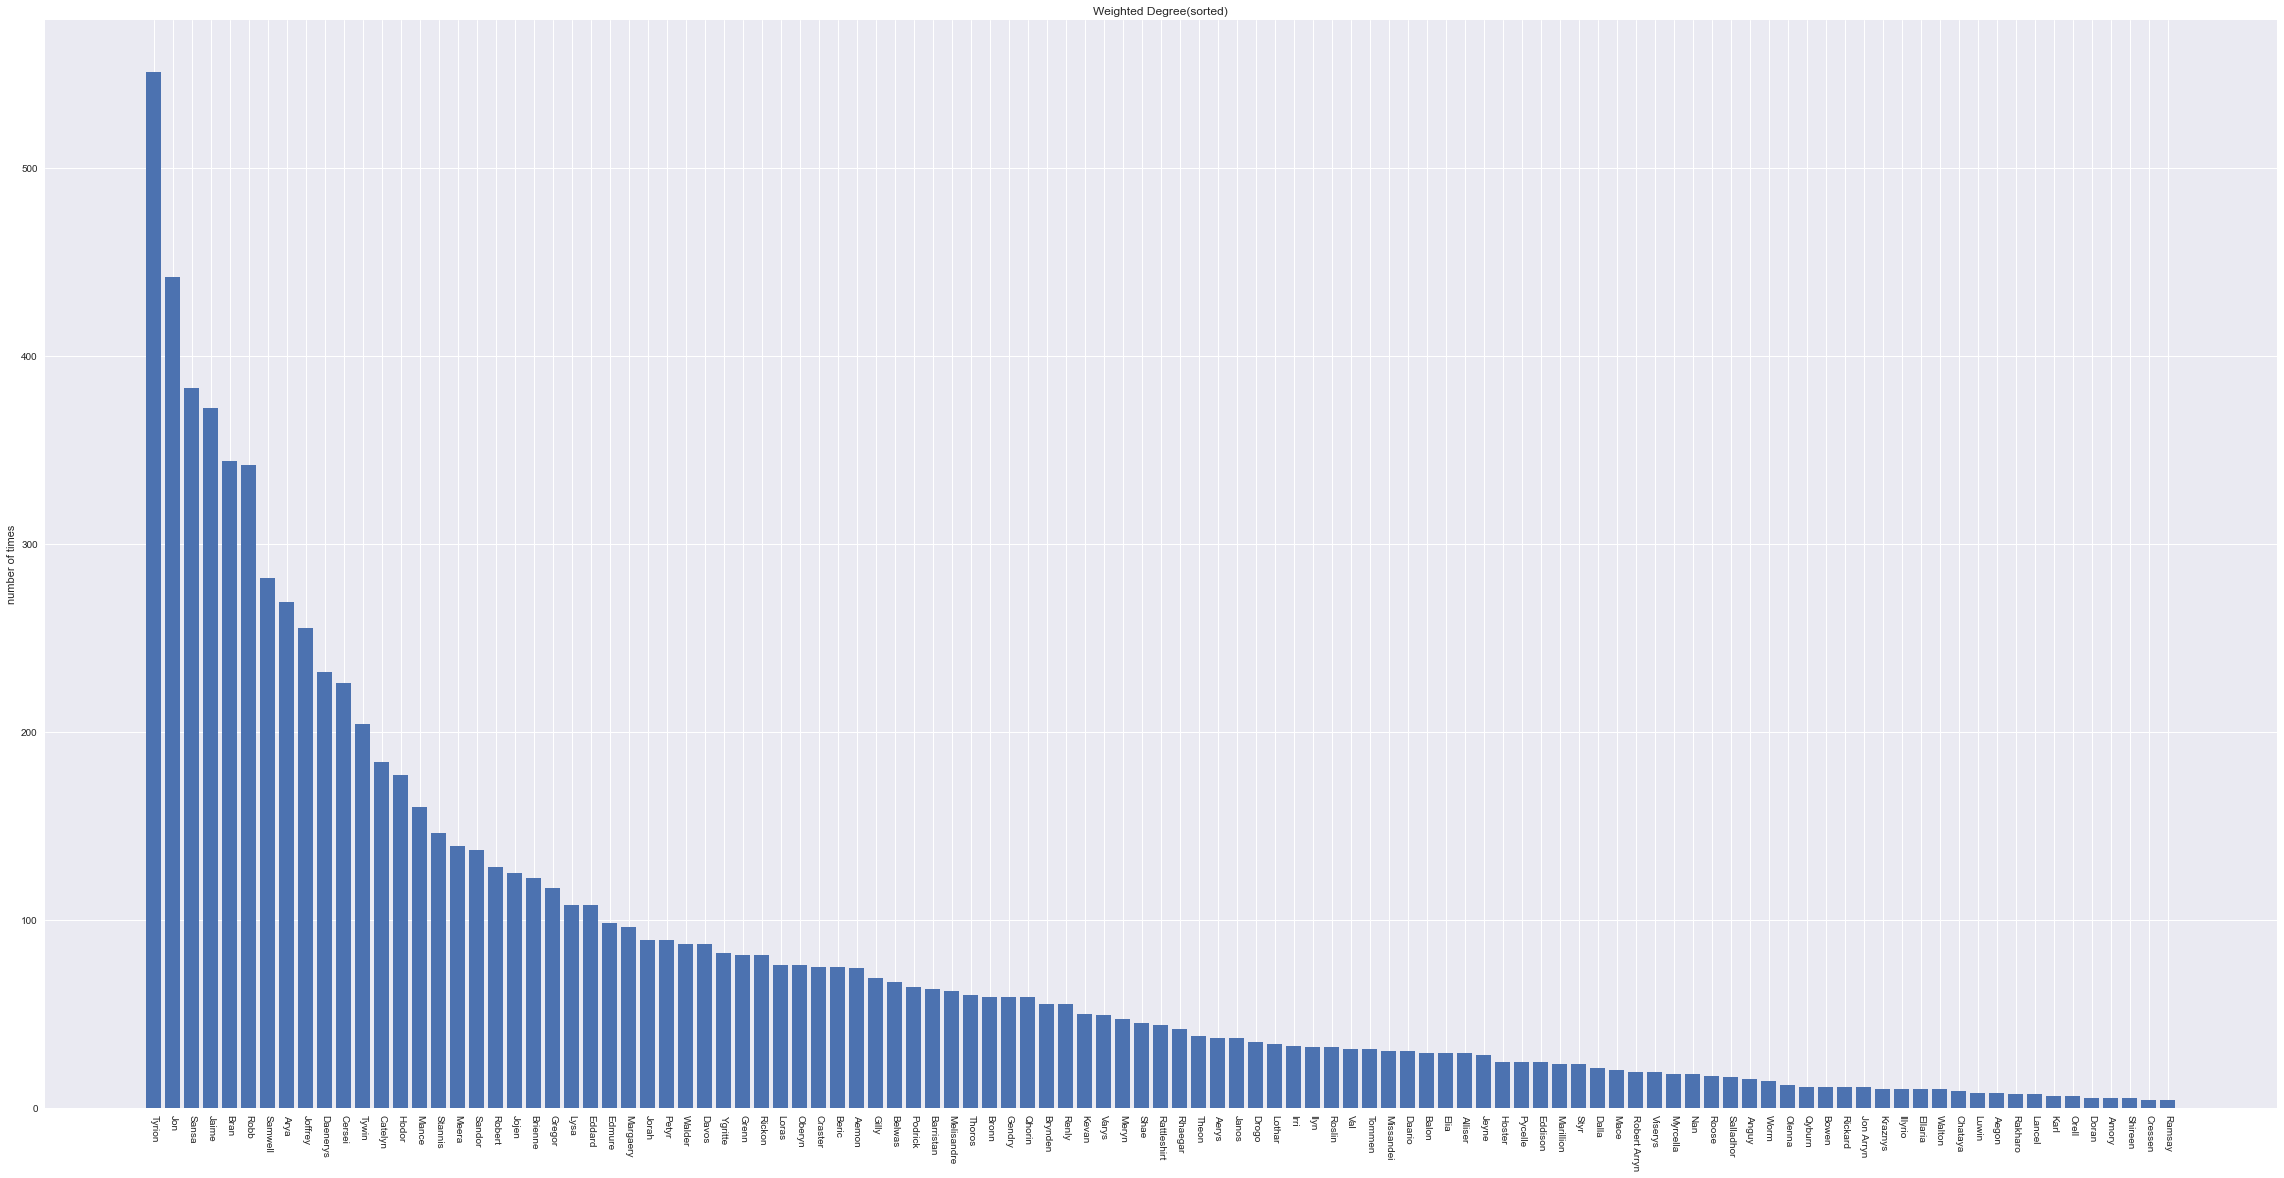

In [25]:
plt.figure(figsize=(40, 20))
plt.bar(appear_n["character"], appear_n["n"]);
plt.title("Weighted Degree(sorted)")
plt.ylabel("number of times");
plt.xticks(rotation=-90);

* 平均每个角色登场80次，有33名角色登场次数在平均值之上
* 登场次数前三和度前三的结果相同
* 登场次数最多的角色是Tyrion Lannister

### 网络直径和平均路径长度

In [26]:
spl = list(nx.all_pairs_shortest_path_length(G))

In [27]:
import functools
spl = list(nx.all_pairs_shortest_path_length(G))
spl = functools.reduce(lambda x, y: list(x) + list(y), [y[1].values() for y in [x for x in spl]])

In [28]:
import collections
counter = collections.Counter(spl)
del counter[0]

In [29]:
max(counter.keys())

6

**网络直径为6**

In [30]:
sum([counter[i] * i for i in counter]) / sum(counter.values())

2.903897019925939

**平均最短路长2.9**

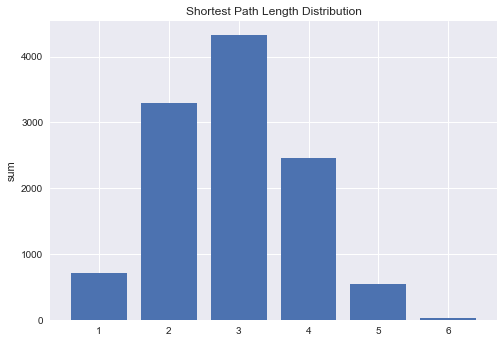

In [31]:
plt.figure()
plt.bar(counter.keys(), counter.values());
plt.title("Shortest Path Length Distribution")
plt.ylabel("sum");

* 可见该网络符合小世界特性

### 聚类系数

In [32]:
clu = nx.clustering(G)

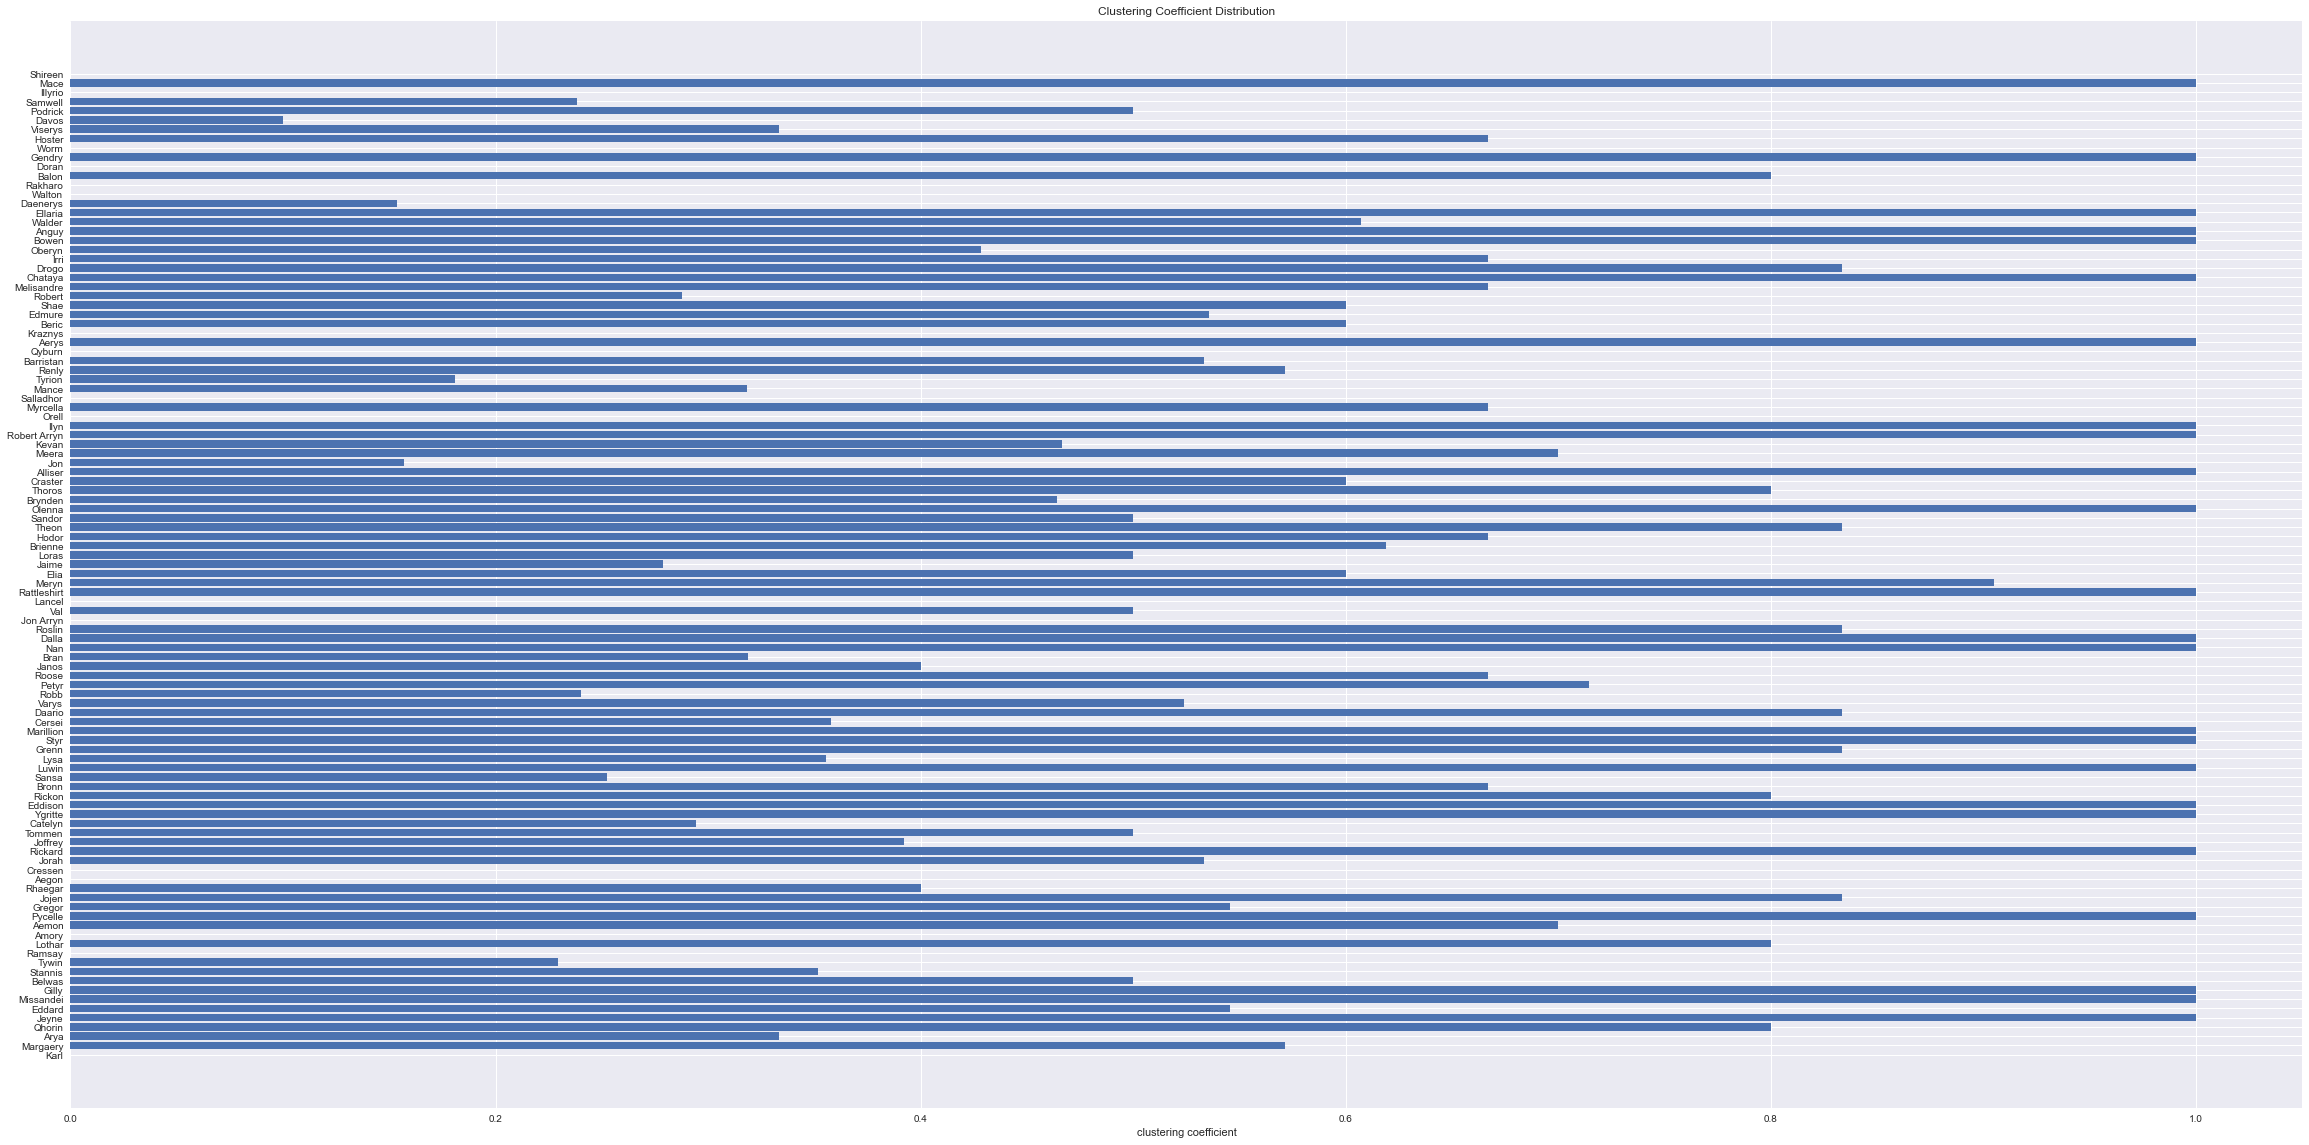

In [33]:
plt.figure(figsize=(40, 20))
plt.barh(list(clu.keys()), list(clu.values()));
plt.title("Clustering Coefficient Distribution")
plt.xlabel("clustering coefficient");

In [34]:
nx.average_clustering(G)

0.551443151559996

**图的平均聚类系数为0.55**

图的连接程度一般（看下面的图更容易理解）

## 图的绘制

In [35]:
options = {
    "node_color": np.random.rand(len(G.nodes)),
#     "edge_color": np.random.rand(len(data.index)),
    "width": 0.5,
#     "edge_cmap": plt.cm.rainbow,
    "cmap": plt.cm.rainbow,
    "with_labels": True,
    "node_size": 80,
    "font_size": 8
}

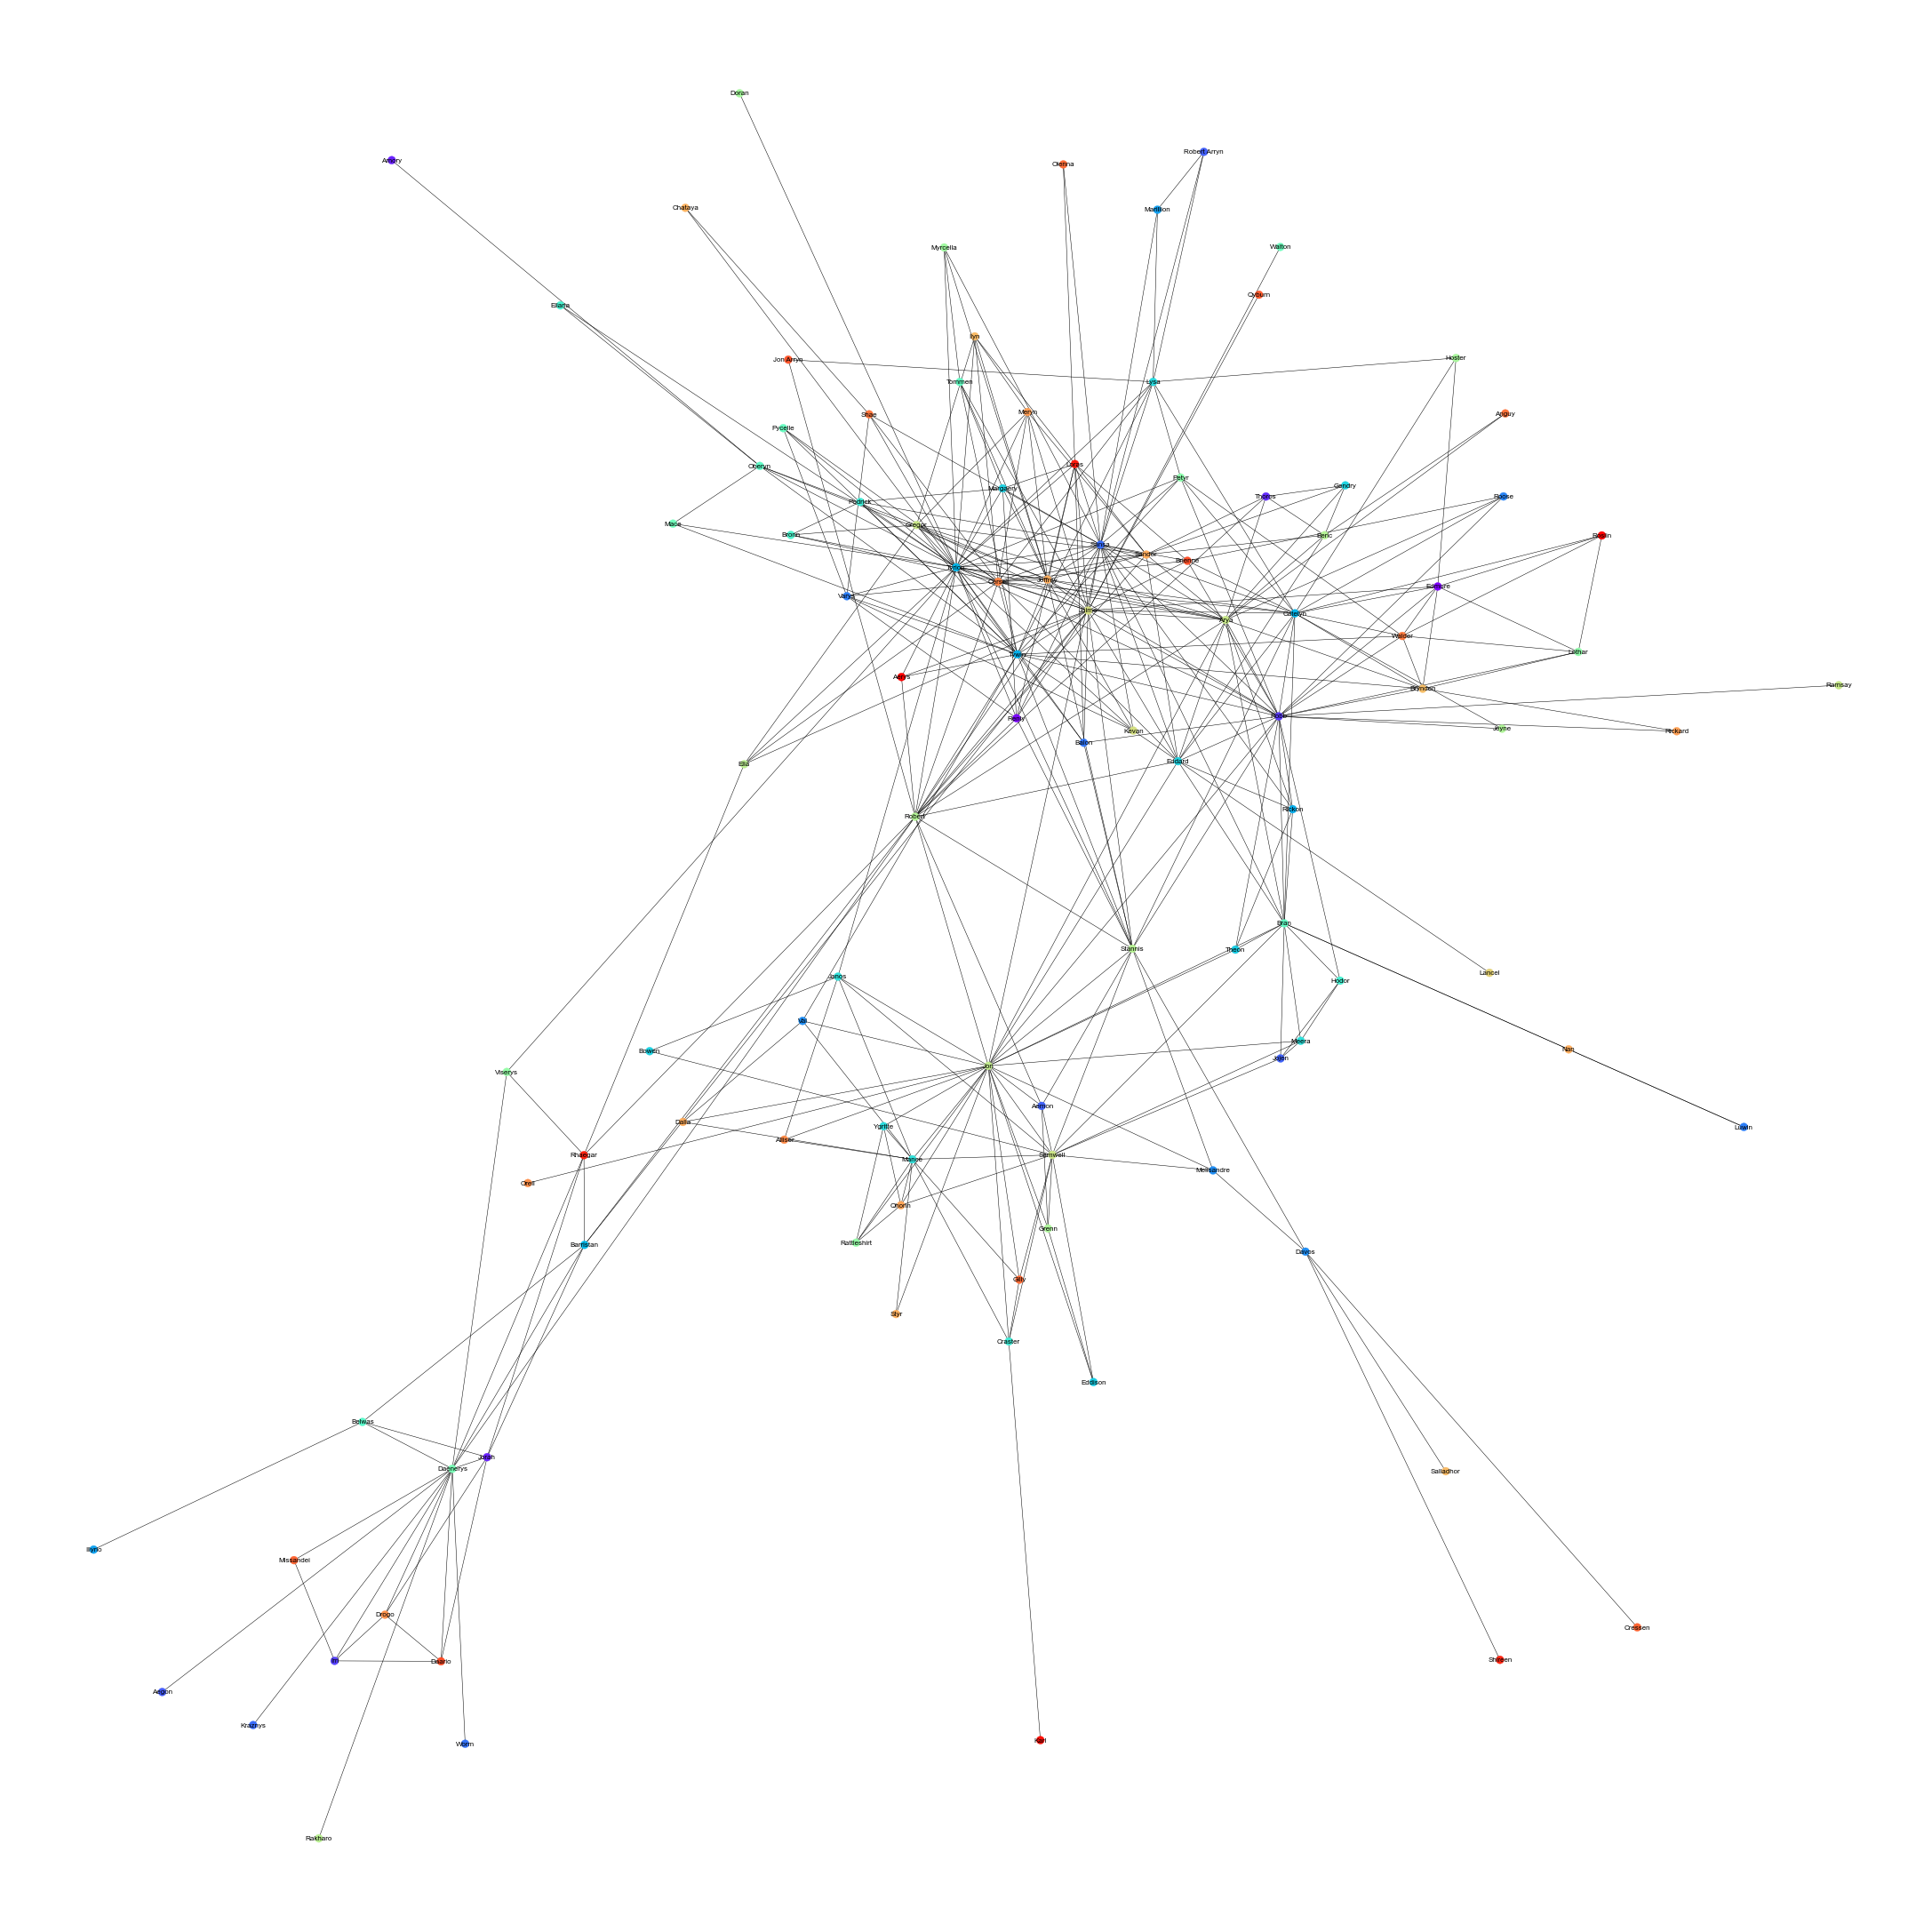

In [36]:
plt.figure(figsize=(30, 30))
nx.draw(G, **options)

In [37]:
pos = nx.circular_layout(G)

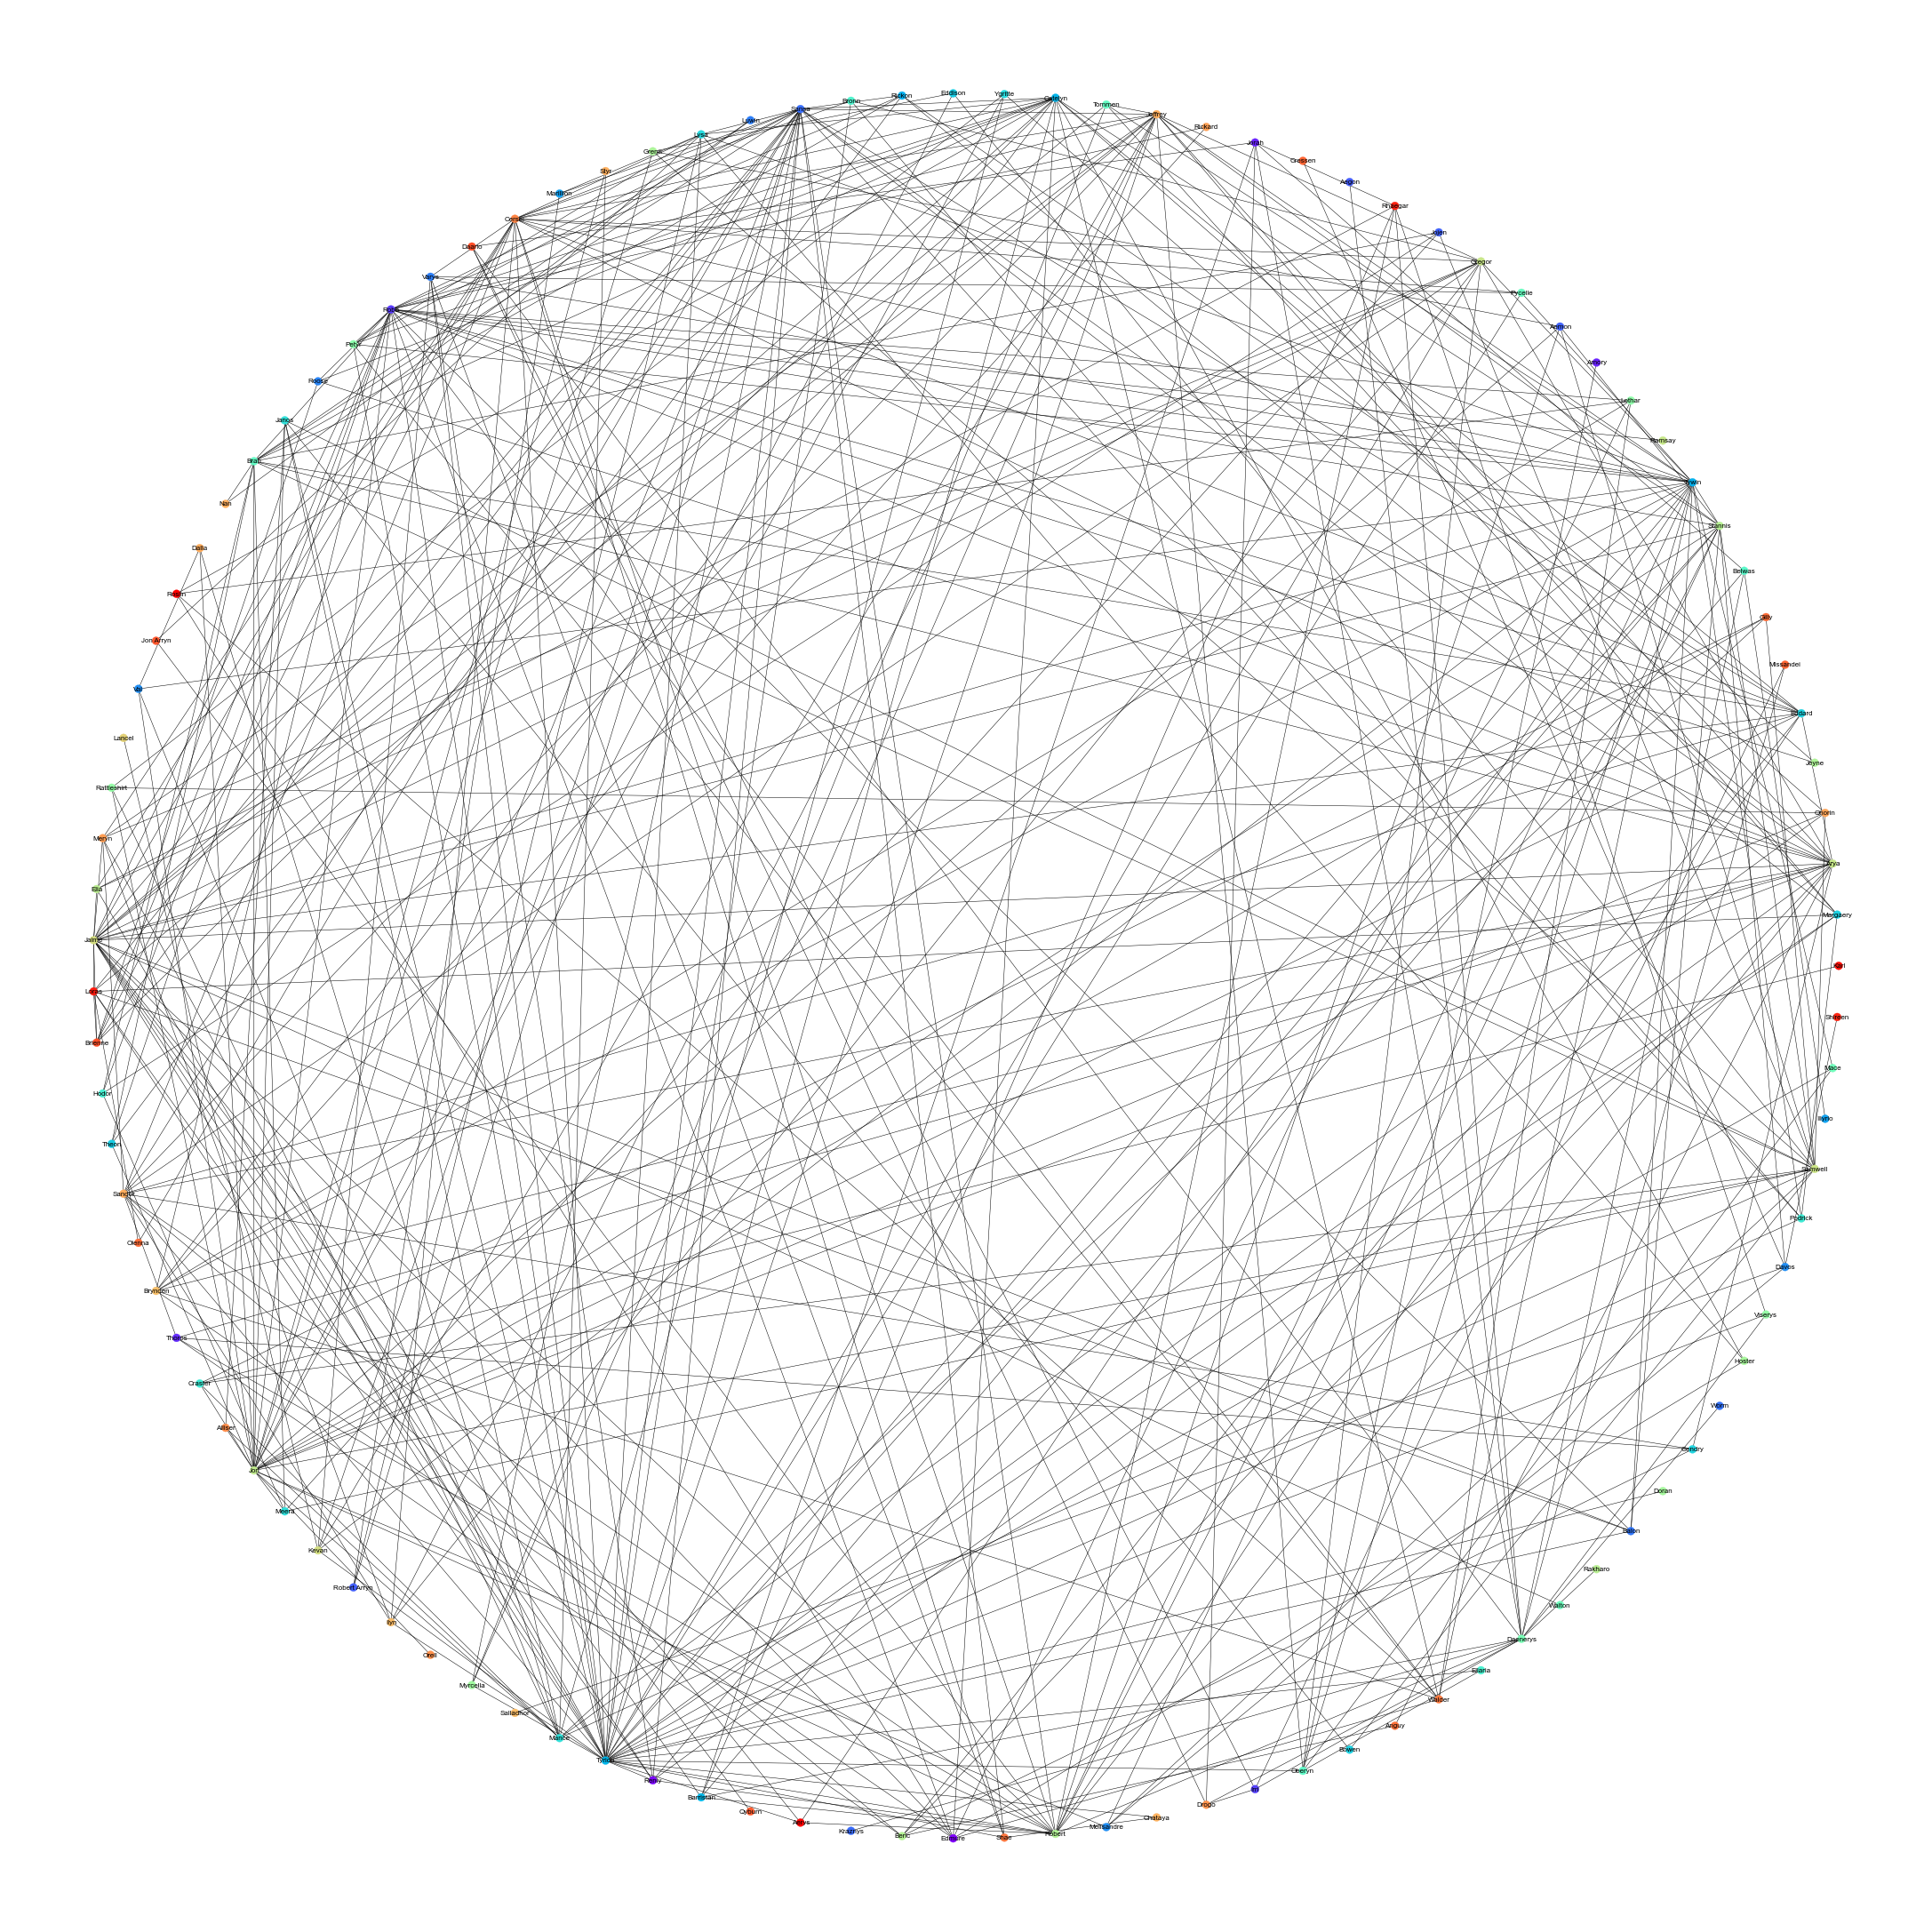

In [38]:
plt.figure(figsize=(30, 30))
nx.draw(G, pos, **options)

几种布局模式：
* nx.bipartite_layout
* nx.circular_layout
* nx.fruchterman_reingold_layout
* nx.kamada_kawai_layout
* nx.multipartite_layout
* nx.planar_layout
* nx.random_layout
* nx.rescale_layout
* nx.shell_layout
* nx.spectral_layout
* nx.spiral_layout
* nx.spring_layout

## 更多的讨论

角色太多不易于展示，这里依此反复剔除度最少的节点

In [39]:
G2 = G.copy()

In [40]:
for c, d in zip(degree["character"].values, degree["degree_value"].values):
    if d < 6.5:
        G2.remove_node(c)

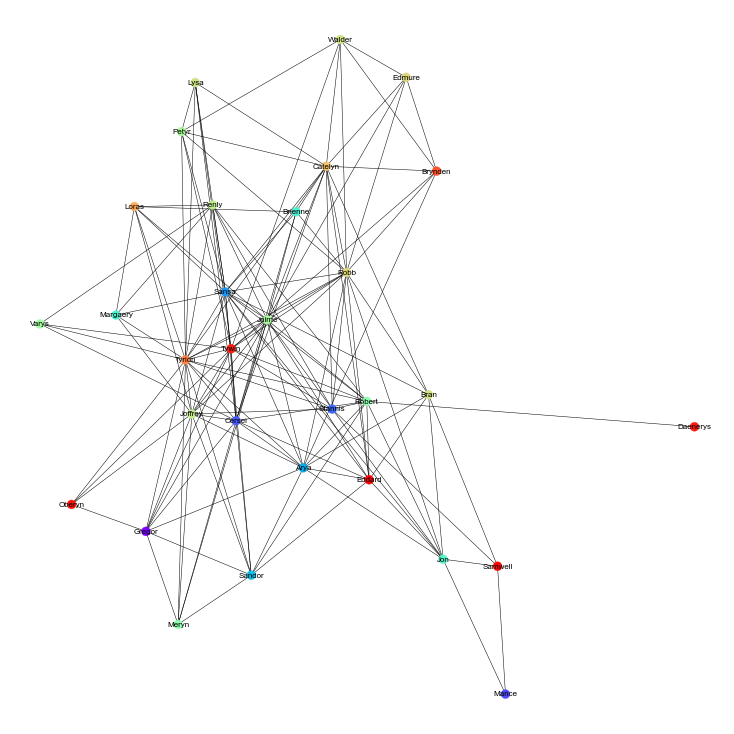

In [41]:
options["node_color"] = np.random.rand(len(G2))
plt.figure(figsize=(10, 10))
nx.draw(G2, **options)

重新计算网络的度分布:

In [42]:
characters2 = list(G2.nodes)
degree2 = [G2.degree(c) for c in characters2]
degree2 = pd.DataFrame({"character": characters2, "degree_value": degree2})
degree2 = degree2.sort_values(by=["degree_value"], ascending=False)
degree2.head()

character  degree_value
23    Tyrion            20
8      Sansa            18
16     Jaime            17
12      Robb            16
10    Cersei            15

第一仍是Tyrion

In [43]:
degree2.tail()

character  degree_value
27    Oberyn             4
11     Varys             4
30   Samwell             4
22     Mance             2
29  Daenerys             1

奇怪的是Daenerys的度很低（看数据集的名字就能知道原因）